##### Import modules and set up file locations

In [1]:
import Sequence_Analysis_Routines as sar
import Sequence_Analysis_Routines
import random
from joblib import Parallel, delayed
from tqdm import tqdm
import matplotlib.pyplot as plt
import logomaker as lm
import math
import pandas as pd

In [2]:
project_dir = 'D:/Project_Data/Project_3'
sonic_paranoid_run_name = 'Run_0'
genome_datasets_dir = project_dir + '/Datasets/NCBI_Datasets_Close_Species/'
output_dir = project_dir + '/Output/Close_Species'
protein_fasta_output_loc = output_dir + '/Protein_Sequences'
sonic_paranoid_output_loc = output_dir + '/Sonic_Paranoid_Output'
ortholog_file_ref = sonic_paranoid_output_loc + '/runs/' + sonic_paranoid_run_name + '/ortholog_groups/flat.ortholog_groups.tsv'
single_copy_ortholog_file_ref = sonic_paranoid_output_loc + '/runs/' + sonic_paranoid_run_name + '/ortholog_groups/single-copy_groups.tsv'
non_cds_output_dir = output_dir + '/Multiple_Alignment_Data/Non_CDS'
upstream_non_cds_output_dir = output_dir + '/Multiple_Alignment_Data/Upstream_Non_CDS'
cds_output_dir = output_dir + '/Multiple_Alignment_Data/CDS'

In [3]:
tb_species = 'GCF_000195955.2'

##### Determine genomes in ortholog family, generate protein files and run Sonic Paranoid

In [4]:
genome_ids = sar.list_dirs(genome_datasets_dir)
num_ids = len(genome_ids)

In [ ]:
for folder in sar.tqdm(genome_ids):
    sar.generate_protein_file(genome_datasets_dir + '/' + folder + '/genomic.gbff', protein_fasta_output_loc + '/' + folder + '.faa')

In [ ]:
#sar.run_sonic_paranoid(protein_fasta_output_loc, sonic_paranoid_output_loc, sonic_paranoid_run_name)

##### Generate ortholog object and object containing sequence information for each ortholog group / species

In [5]:
orthologs = sar.Ortholog_Grouping(ortholog_file_ref)

100%|██████████| 28704/28704 [00:01<00:00, 17270.83it/s]


In [6]:
offset = 50

In [7]:
seq_data = sar.Ortholog_Sequence_Dataset(orthologs, genome_datasets_dir, genome_ids, offset, tb_species) 

100%|██████████| 6/6 [00:15<00:00,  2.51s/it]


##### Perform CDS and non-CDS alignments for each full ortholog group and save to folders

In [8]:
min_species = num_ids
num_cores = 16
core_numbers = list(range(1, num_cores+1))
groups = random.sample(orthologs.full_ortholog_groups, len(orthologs.full_ortholog_groups))  #Permutation ensures even distribution of processing speeds
#par = Parallel(n_jobs=-1)(delayed(sar.align_and_build)(groups, num_cores, core_number, seq_data.sequence_data, 'cds_length', 'cds_seq', cds_output_dir+'/', min_species) for core_number in tqdm(core_numbers))
#par = Parallel(n_jobs=-1)(delayed(sar.align_and_build)(groups, num_cores, core_number, seq_data.sequence_data, 'non_cds_offset_length', 'non_cds_offset_seq', non_cds_output_dir+'/', min_species) for core_number in tqdm(core_numbers))
par = Parallel(n_jobs=-1)(delayed(sar.align_and_build)(groups, num_cores, core_number, seq_data.sequence_data, 'upstream_non_cds_offset_length', 'upstream_non_cds_offset_seq', upstream_non_cds_output_dir+'/', min_species) for core_number in tqdm(core_numbers))

100%|██████████| 16/16 [00:00<00:00, 347.81it/s]


##### Remove portions of alignment gapped for TB and plot entropies and logos

In [15]:
group_id = 2464
alignment = sar.Alignment(non_cds_output_dir+'/'+str(group_id)+'.fasta', tb_species, 'NT')
alignment.modify_sequence(consensus=1)
alignment.calculate_entropies(mvave_len = 10)

In [16]:
utr_upstream_dict = {}
utrs = pd.read_csv(project_dir + '/Datasets/Data_From_Publications/strict_3UTRs.csv', header=0)
for i, r in tqdm(utrs.iterrows(), total=utrs.shape[0]):
    utr_upstream_dict[r['upstream']] = [r['utr'], r['start']-1, r['stop']-1, r['strand'], r['downstream']]
#putative_srna_dict = {}
#psrnas = pd.read_csv(project_dir + '/Datasets/Data_From_Publications/intergenic_putative_srnas.csv', header=0)
#for i, r in tqdm(utrs.iterrows(), total=utrs.shape[0]):
#    putative_srna_dict[r['upstream']] = [r['utr'], r['start']-1, r['stop']-1, r['strand'], r['downstream']]

100%|██████████| 586/586 [00:00<00:00, 24414.07it/s]


In [18]:
cds_end_pos = offset - 1
non_cds_end_pos = alignment.modified_sequence_length - offset
non_cds_offset_start = seq_data.master_species_info(group_id, 'non_cds_offset_start')
non_cds_offset_stop = seq_data.master_species_info(group_id, 'non_cds_offset_stop')
locus_tag = seq_data.master_species_info(group_id, 'locus_tag')
cds_strand = seq_data.master_species_info(group_id, 'strand')
if cds_strand == 1:
    downstream_locus_tag = seq_data.master_species_info(group_id, 'next_locus_tag')
    downstream_locus_strand = seq_data.master_species_info(group_id, 'next_strand')
else:
    downstream_locus_tag = seq_data.master_species_info(group_id, 'previous_locus_tag')
    downstream_locus_strand = seq_data.master_species_info(group_id, 'prev_strand')
utr_start_pos = 0
utr_end_pos = 0
if locus_tag in utr_upstream_dict:
    utr_data = utr_upstream_dict[locus_tag]
    if cds_strand == 1:
        utr_start_pos = utr_data[1] - non_cds_offset_start
        utr_end_pos = utr_data[2] - non_cds_offset_start
    else:
        utr_start_pos = non_cds_offset_stop - utr_data[2]
        utr_end_pos = non_cds_offset_stop - utr_data[1]

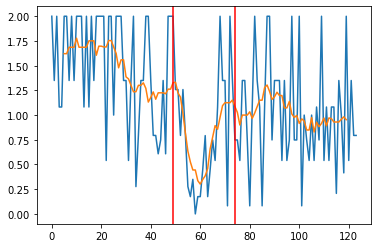

In [19]:
plt.plot(alignment.relative_entropy);
plt.plot(alignment.mvave_relative_entropy);
plt.axvline(x=cds_end_pos, ymin=0, ymax=2, color='r');
plt.axvline(x=non_cds_end_pos, ymin=0, ymax=2, color='r');

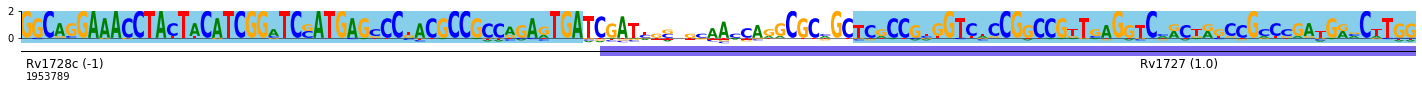

In [20]:
counts_df = lm.alignment_to_matrix(sequences = alignment.modified_sequence_list, to_type = 'counts', characters_to_ignore = '-', pseudocount=0)
background_probs = [0.25, 0.25, 0.25, 0.25]
for i, r in counts_df.iterrows():
    temp_relent = []
    num_gaps = alignment.num_sequences
    for k in range(4):
        num_gaps = num_gaps - r.iloc[k]
    for k in range(4):
        ct = r.iloc[k] + num_gaps*background_probs[k]
        if ct == 0:
            temp_relent.append(0)
        else:
            temp_relent.append((ct /alignment.num_sequences) * math.log((ct /alignment.num_sequences)/background_probs[k],2))
    for k in range(4):
        r.iloc[k] = temp_relent[k]

y = -1        
seqlogo = lm.Logo(counts_df, figsize = [25,1])
seqlogo.highlight_position_range(pmin=0, pmax=cds_end_pos, color='skyblue')
for i in alignment.master_species_modified_sequence_insertions:
    seqlogo.highlight_position_range(pmin=i, pmax=i, color='rosybrown')
seqlogo.highlight_position_range(pmin=non_cds_end_pos, pmax=alignment.modified_sequence_length, color='skyblue')
seqlogo.ax.plot([utr_start_pos, utr_end_pos],[y, y], color='mediumslateblue', linewidth=10, solid_capstyle='butt')
seqlogo.ax.text(0,2.2*y,locus_tag + ' ('+str(cds_strand)+')',fontsize=12)
seqlogo.ax.text(alignment.modified_sequence_length - offset/2,2.2*y,downstream_locus_tag+ ' ('+str(downstream_locus_strand)+')',fontsize=12)
seqlogo.ax.text(0, 2.5*y,int(non_cds_offset_start), verticalalignment='top', horizontalalignment='left')
    
seqlogo.style_spines(visible=False)
seqlogo.style_spines(spines=['left'], visible=True, bounds=[0, 2])
seqlogo.ax.set_xticks([])
seqlogo.ax.set_yticks([0,2])
seqlogo.ax.set_ylim([-2, 2])
seqlogo.ax.axhline(y, color = 'k', linewidth = 1)
seqlogo;

In [ ]:
alignment.master_species_modified_sequence_insertions

In [ ]:
alignment.master_species_modified_sequence

In [ ]:
seq_data.master_species_info(441, 'non_cds_length')